In [ ]:
pip install scikit-learn pandas numpy scipy

Note: you may need to restart the kernel to use updated packages.


1.KNN
SHAILJA PATIL
24CS60R49

CHECK ON DATA IMPORT

In [ ]:
import pandas as pd

# Load your dataset (adjust the filename and path as necessary)
df = pd.read_csv('test.csv')
# Inspect the first few rows to ensure it's loaded correctly
print(df.head())


                                               tweet label
0  The CDC currently reports 99031 deaths. In gen...  real
1  States reported 1121 deaths a small rise from ...  real
2  Politically Correct Woman (Almost) Uses Pandem...  fake
3  #IndiaFightsCorona: We have 1524 #COVID testin...  real
4  Populous states can generate large case counts...  real


INSTALL NLTK EMOJI TO HANDLE EMOJIES

split the data
into train test

In [ ]:
pip install nltk emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


DATA PREPROCESSING

In [ ]:
import pandas as pd
import re
import emoji
import nltk
from sklearn.model_selection import train_test_split

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Function to preprocess the text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove URLs AND MENTIONS
    text = re.sub(r'http\S+', 'URL', text)
    text = re.sub(r'@\w+', 'USER', text)

    # Replacing the  emojis with their names, to convert emojis to text descriptions.
    text = emoji.demojize(text)

    # To Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords (words that don't add much meaning)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Join tokens
    processed_text = ' '.join(tokens)
    return processed_text

# Load your dataset
df = pd.read_csv('test.csv')

# Preprocess the text data in the dataset
df['processed_text'] = df['tweet'].apply(preprocess_text)

# Split into 80% train, 10% validation, and 10% test
train_data, temp_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, shuffle=True, random_state=42)

# Save the splits into separate CSV files for each
train_data[['processed_text', 'label']].to_csv('train_split.csv', index=False)
val_data[['processed_text', 'label']].to_csv('val_split.csv', index=False)
test_data[['processed_text', 'label']].to_csv('test_split.csv', index=False)

# to Check the sizes of the splits
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")


[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training data size: 8480
Validation data size: 1060
Test data size: 1060


TF-IDF vectorizer

In [ ]:
# Importing the necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
train_data = pd.read_csv('train_split.csv')
val_data = pd.read_csv('val_split.csv')
test_data = pd.read_csv('test_split.csv')

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  #  max_features set to 5000

# Fit and transform the training data to obtain TF-IDF vectors
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['processed_text'])

# Transform the validation and test data using the same fitted vectorizer
X_val_tfidf = tfidf_vectorizer.transform(val_data['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_data['processed_text'])

# Optionally, check the shape of the transformed data
print(f"TF-IDF Training Data Shape: {X_train_tfidf.shape}")
print(f"TF-IDF Validation Data Shape: {X_val_tfidf.shape}")
print(f"TF-IDF Test Data Shape: {X_test_tfidf.shape}")


TF-IDF Training Data Shape: (8480, 5000)
TF-IDF Validation Data Shape: (1060, 5000)
TF-IDF Test Data Shape: (1060, 5000)


KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Get the target labels for training and test sets
y_train = train_data['label']
y_test = test_data['label']

# Initialize the K-Nearest Neighbors classifier
knn = KNeighborsClassifier()

#the hyperparameters to tune
param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15],          # The number of neighbors
    'metric': ['euclidean', 'manhattan', 'cosine'],  # Distance metrics to use
    'weights': ['uniform', 'distance'],  # Weights assigned to neighbors
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute the nearest neighbors
}

#GridSearchCV for hyperparameter optimization
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_tfidf, y_train)

# Get the best hyperparameters found by GridSearchCV
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Use the best model from GridSearchCV to predict on the test set
best_knn_model = grid_search.best_estimator_

# Make predictions on the test set
y_test_pred = best_knn_model.predict(X_test_tfidf)

# TO Evaluate performance
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# TO Calculate accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


Fitting 5 folds for each of 120 candidates, totalling 600 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py", line 239, in fit
    return self._fit(X

Best Hyperparameters: {'algorithm': 'auto', 'metric': 'cosine', 'n_neighbors': 15, 'weights': 'distance'}
Classification Report on Test Set:
              precision    recall  f1-score   support

        fake       0.90      0.88      0.89       496
        real       0.90      0.91      0.91       564

    accuracy                           0.90      1060
   macro avg       0.90      0.90      0.90      1060
weighted avg       0.90      0.90      0.90      1060

Test Accuracy: 0.8981


CONFUSION MATRIX

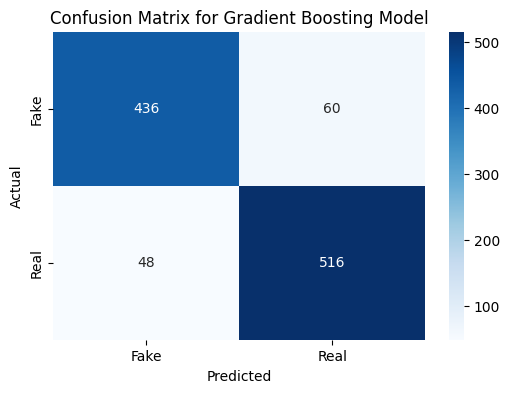

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# TO Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
# TO Display confusion matrix n
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
